# Plot

In [1]:
import os
import os.path
import numpy as np
import time
from tqdm import tqdm
from sklearn.metrics import median_absolute_error, mean_squared_error

assert os.path.exists('data')

In [2]:
def load_dataset(data_source_filename):
  print("Loading %s... " % data_source_filename.split("/")[-1], end="")
  t = time.time()
  dataset = dict()
  with np.load(data_source_filename, allow_pickle=True) as source_file:
    for key in source_file.keys():
      # print(key)
      dataset[key] = source_file[key].tolist()
  print("done (%.1fs)" % (time.time()-t), flush=True)
  return dataset

data_source_filenames = [os.path.join('data', fn) for fn in os.listdir('data')
                            if os.path.isfile(os.path.join('data', fn)) and fn[-3:]=='npz']
data_source_filenames

['data/StClare_facs_danish.npz',
 'data/SDHK_Latin.npz',
 'data/StClare_facs_latin.npz',
 'data/StClare_dipl_danish.npz',
 'data/StClare_dipl_latin.npz',
 'data/SDHK_Swedish.npz',
 'data/Colonia.npz',
 'data/SemEval2015.npz']

## Scatterplot for prediction accuarcy

In [3]:
from operator import concat
from functools import reduce
flatten = lambda t: reduce(concat, t)

plot_feature_sets = ['character_ngram_2', 'char_2_25']
data = dict()
data_length = dict()
for i, data_source_filename in enumerate(data_source_filenames):
    name = data_source_filename.split(".")[0].split("/")[-1]
    dataset = load_dataset(data_source_filename)
    years = np.asarray([np.mean(item['date']) if type(item['date']) is tuple else item['date'] for item in dataset['data']], np.int)
    # Find the length of the data (either characters or tokens)
    if 'text' in dataset['data'][0].keys():
        data_length[name] = [len(dataset['data'][i]['text']) for i in dataset['folds']['test']]
    else:
        data_length[name] = [len(flatten(dataset['data'][i]['tokens'])) if len(dataset['data'][i]['tokens'])>0 else 0 for i in dataset['folds']['test']]
    for estimator in ['gaussianprocess', 'linearsvc', 'temporallm']:
        if i == 0:
            print("%s feature sets:", (estimator, dataset[estimator].keys()))
    for estimator in ['gaussianprocess', 'linearsvc', 'temporallm']:
        print(" %s" % estimator)
        for fs in dataset[estimator].keys():
            if estimator is 'gaussianprocess':
                mae = median_absolute_error(dataset[estimator][fs]['y_true_regr'], dataset[estimator][fs]['y__pred_regr'])
                rmse = np.sqrt(mean_squared_error(dataset['gaussianprocess'][fs]['y_true_regr'], dataset['gaussianprocess'][fs]['y__pred_regr']))
            else:
                mae = median_absolute_error(dataset[estimator][fs]['y_true'], dataset[estimator][fs]['y_pred'])
                rmse = np.sqrt(mean_squared_error(dataset[estimator][fs]['y_true'], dataset[estimator][fs]['y_pred']))
            print("  %s, %.1f, %.1f, %.1f" % (fs, dataset[estimator][fs]['accuracy']*100, mae, rmse))
        if (plot_feature_sets[0] in dataset[estimator].keys()) or (plot_feature_sets[1] in dataset[estimator].keys()):
            if name not in data.keys():
                data[name] = dict()
            if estimator is 'temporallm':
                data[name][estimator] = {'span': (np.min(years), np.min(years)),
                                         'y_est': dataset[estimator][plot_feature_sets[1]]['y_pred'],
                                         'y_true': dataset[estimator][plot_feature_sets[1]]['y_true']}
            elif 'y_true_regr' in dataset[estimator][plot_feature_sets[0]].keys():
                data[name][estimator] = {'span': (np.min(years), np.min(years)),
                                         'y_est': dataset[estimator][plot_feature_sets[0]]['y__pred_regr'],
                                         'y_true': dataset[estimator][plot_feature_sets[0]]['y_true_regr']}
            else:
                data[name][estimator] = {'span': (np.min(years), np.min(years)),
                                         'y_est': dataset[estimator][plot_feature_sets[0]]['y_pred'],
                                         'y_true': dataset[estimator][plot_feature_sets[0]]['y_true']}

Loading StClare_facs_danish.npz... done (0.1s)
%s feature sets: ('gaussianprocess', dict_keys(['bow_words', 'tfidf_words', 'character_ngram_1', 'character_ngram_2', 'character_ngram_3', 'word_ngram_1', 'word_ngram_2', 'word_ngram_3']))
%s feature sets: ('linearsvc', dict_keys(['bow_words', 'tfidf_words', 'character_ngram_1', 'character_ngram_2', 'character_ngram_3', 'word_ngram_1', 'word_ngram_2', 'word_ngram_3']))
%s feature sets: ('temporallm', dict_keys(['word_1_50', 'word_1_25', 'char_1_50', 'char_1_25', 'word_2_50', 'word_2_25', 'char_2_50', 'char_2_25', 'word_3_50', 'word_3_25', 'char_3_50', 'char_3_25', 'word_5_50', 'word_5_25', 'char_5_50', 'char_5_25']))
 gaussianprocess
  bow_words, 21.1, 38.6, 45.3
  tfidf_words, 21.1, 38.6, 45.3
  character_ngram_1, 26.3, 16.0, 32.5
  character_ngram_2, 21.1, 38.6, 45.3
  character_ngram_3, 21.1, 38.6, 45.3
  word_ngram_1, 21.1, 38.6, 45.3
  word_ngram_2, 31.6, 28.1, 36.7
  word_ngram_3, 21.1, 38.6, 45.3
 linearsvc
  bow_words, 15.8, 50.0, 

/home/fredrik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


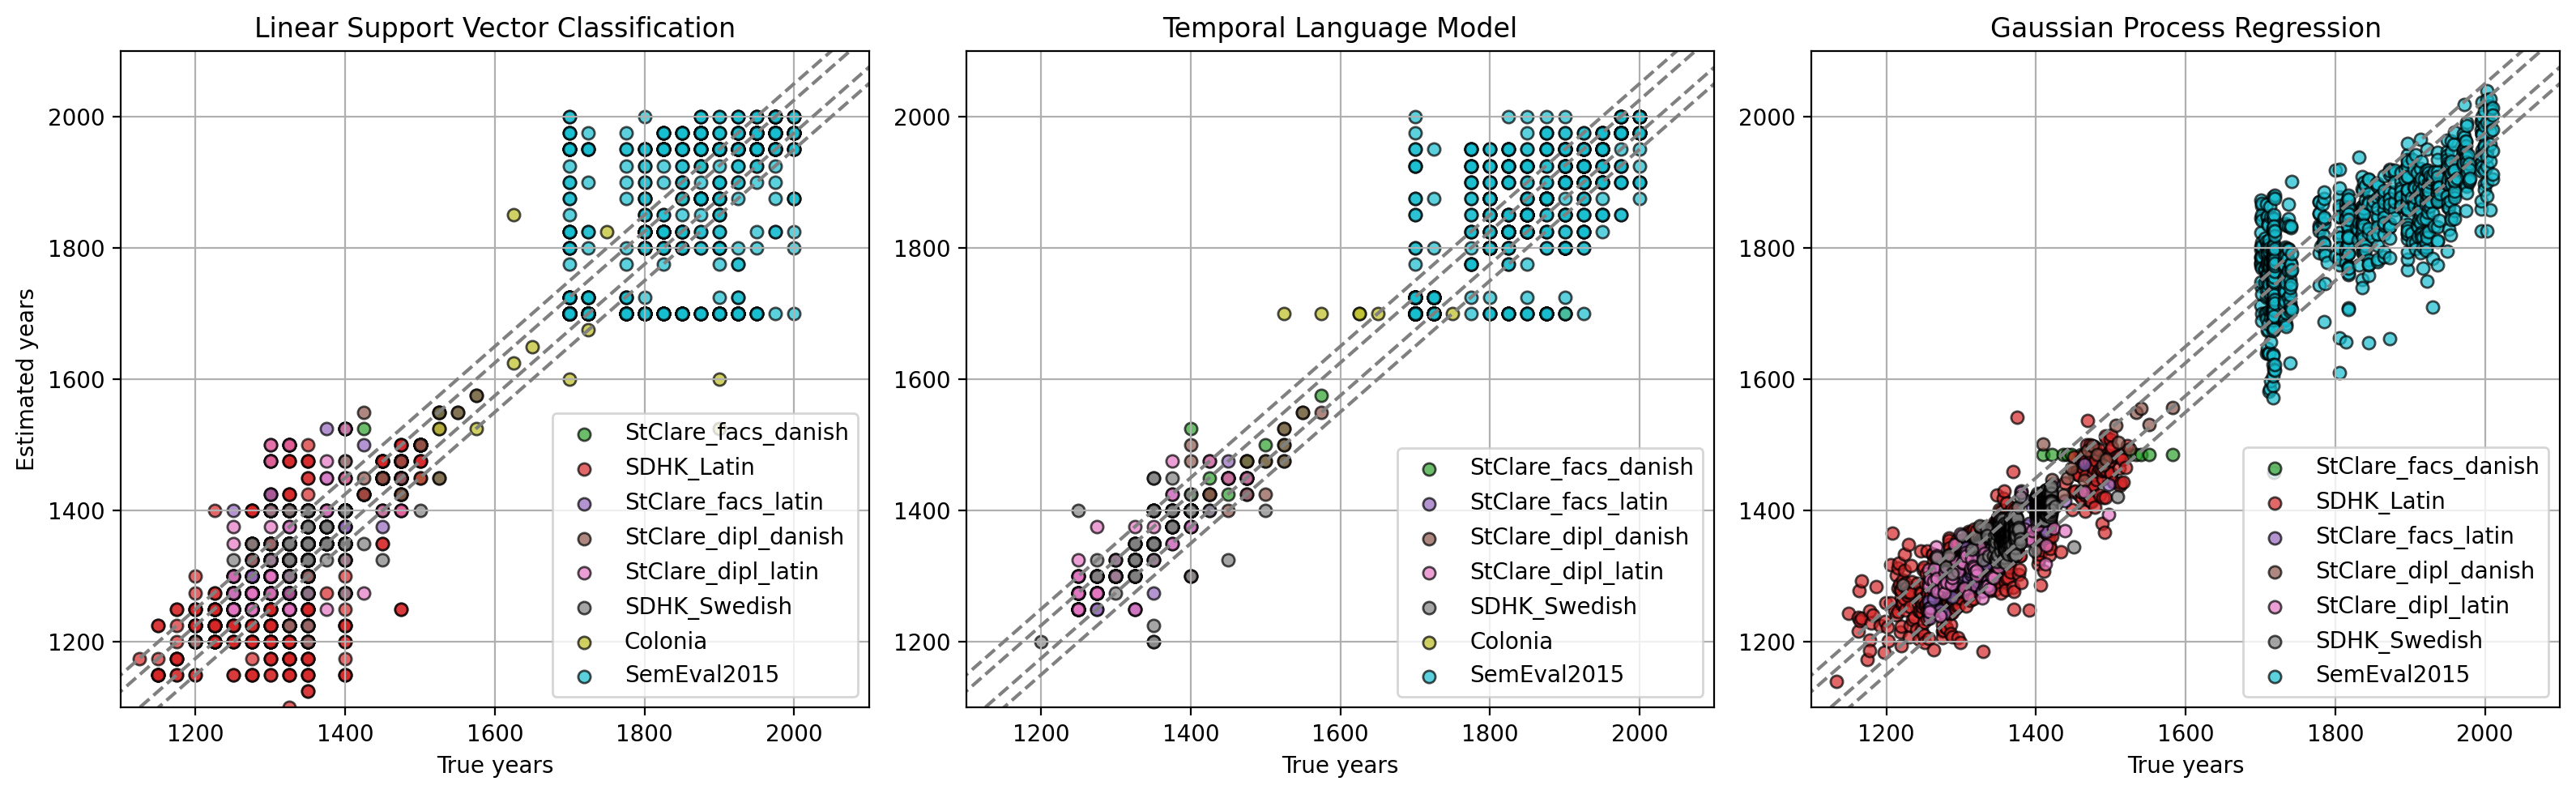

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plt_ticker

estimators = ['linearsvc', 'temporallm', 'gaussianprocess']

fig = plt.figure(figsize=(16, 5), dpi=200)
ax = fig.subplots(1, 3)
ax[0].set_title("Linear Support Vector Classification")
ax[1].set_title('Temporal Language Model')
ax[2].set_title('Gaussian Process Regression')

for c, name in enumerate(data):
    for i, estimator in enumerate(estimators):
        if estimator in data[name].keys():
            y_true = data[name][estimator]['y_true'].astype(np.float)
            y_est = data[name][estimator]['y_est'].astype(np.float)
            #if i != 2:
            #    y_true += np.random.uniform(-10, 10, size=y_true.shape)
            #    y_est += np.random.uniform(-10, 10, size=y_est.shape)
            #ax[i].scatter(y_true, y_est, c="C%i" % c, s=40, label="%s" % name, cmap='Pastel1', alpha=.5)
            ax[i].scatter(y_true, y_est, c="C%i" % (c+2), s=30, label="%s" % name, alpha=.7, edgecolor='k')

for i in range(len(ax)):
    if i==0:
        ax[i].set_ylabel("Estimated years")
    ax[i].set_xlabel("True years")
    ax[i].legend(loc='lower right')
    #loc = plt_ticker.MultipleLocator(base=25)
    #ax[i].xaxis.set_major_locator(loc)
    #ax[i].yaxis.set_major_locator(loc)
    #ax[i].grid(which='minor', axis='both', linestyle='-')
    ax[i].grid()
    
    x = np.linspace(1000, 2200, 5)
    #ax[i].plot(x, x+23.8, '--', c='gray', alpha=1)
    #ax[i].plot(x, x-23.8, '--', c='gray', alpha=1)
    ax[i].plot(x, x+25, '--', c='gray', alpha=1)
    ax[i].plot(x, x-25, '--', c='gray', alpha=1)
    ax[i].plot(x, x+50, '--', c='gray', alpha=1)
    ax[i].plot(x, x-50, '--', c='gray', alpha=1)

    ax[i].axis((1100, 2100, 1100, 2100))
fig.tight_layout()
fig.show()
plt.savefig("estimations_scatter_plot.png")

### Plotting text length against estimation error

StClare_facs_danish 	0.205	0.40
SDHK_Latin 	nan	nan
StClare_facs_latin 	0.085	0.48
StClare_dipl_danish 	0.210	0.39
StClare_dipl_latin 	0.195	0.10
SDHK_Swedish 	-0.123	0.00
Colonia 	-0.123	0.00
SemEval2015 	-0.181	0.00


/home/fredrik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/fredrik/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/fredrik/anaconda3/lib/python3.7/site-packages/numpy/core/function_base.py:144: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/fredrik/anaconda3/lib/python3.7/site-packages/numpy/core/function_base.py:154: RuntimeWarning: invalid value encountered in add
  y += start
/home/fredrik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


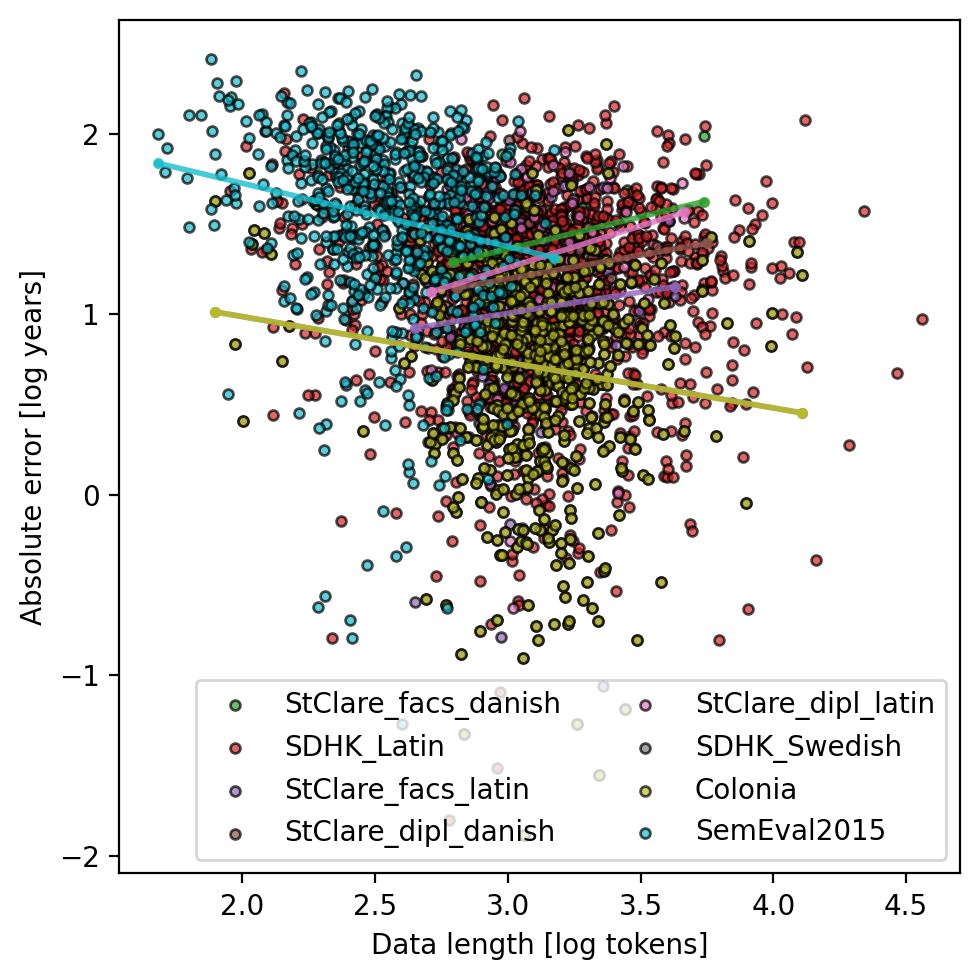

In [6]:
estimators = ['linearsvc', 'temporallm', 'gaussianprocess']
estimators = ['gaussianprocess']
sources = list(data.keys())
#sources = ['SDHK_Swedish']

from scipy.stats import linregress

fig = plt.figure(figsize=(5, 5), dpi=200)
ax = fig.subplots(1, 1)
for i, source in enumerate(sources):
    for j, estimator in enumerate(estimators):
        if estimator in data[source].keys():
            y_true = data[source][estimator]['y_true'].astype(np.float).ravel()
            y_est = data[source][estimator]['y_est'].astype(np.float).ravel()
            error = np.log10(np.abs(y_true-y_est))
            lengths = np.log10(np.asarray(data_length[source]))
        ax.scatter(lengths, error, c="C%i" % (i+2), s=50, label="%s" % source, marker='.', alpha=.7, edgecolor='k')
        slope, intercept, r, p, se = linregress(lengths, error)
        x = np.linspace(lengths.min(), lengths.max(), 2)
        ax.plot(x, slope*x+intercept, '.-', c="C%i" % (i+2), linewidth=2, alpha=.8)
        print("%s \t%.3f\t%.2f" % (source, r, p))
    ax.set_ylabel("Absolute error [log years]")
    ax.set_xlabel("Data length [log tokens]")
    ax.legend(loc='lower right', ncol=2)
fig.tight_layout()
fig.show()
plt.savefig("abs_error_vs_length.png")
plt.savefig("abs_error_vs_length.svg")